In [1]:
import os

os.chdir("../..")
os.getcwd()

'/home/mario/PhD/spatial_lda'

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

In [3]:
covariates = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", 
              "number_of_reviews", "review_scores_rating", "instant_bookable"]

# Run

In [4]:
with open("data/amsterdam.pkl", "rb") as fp:
    datas = pickle.load(fp)

In [5]:
datas.keys()

dict_keys(['y', 'G', 'neigh_names', 'cov'])

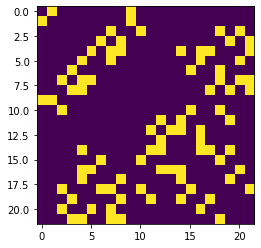

In [6]:
plt.imshow(datas["G"])

In [7]:
covariates_by_group = []
for i, cov in enumerate(datas["cov"]):      
    currDf = cov[covariates].copy()
    if(currDf.isna().sum().sum()):
        print("Nans in group {0}".format(i))
    
    currDf["host_is_superhost"] = currDf["host_is_superhost"].apply(lambda x: int(x == "t"))
    currDf["instant_bookable"] = currDf["instant_bookable"].apply(lambda x: int(x == "t"))
    
    curr = currDf.values.astype(np.float)
    covariates_by_group.append(curr)

In [8]:
for i in range(len(datas["y"])):
    if len(datas["y"][i]) != len(datas["cov"][i]):
        print("error in ", i)
        print("datas: ", len(datas["y"][i]), " covariates", covariates_by_group[i].shape[0])

In [9]:
chains, time = runSpatialMixtureSampler(
    5000, 10000, 2, datas["G"], 
    "spatial_mix/resources/sampler_params.asciipb",
    datas["y"], covariates_by_group)

Burn-in, iter # 200  /  5000
Burn-in, iter # 400  /  5000
Burn-in, iter # 600  /  5000
Burn-in, iter # 800  /  5000
Burn-in, iter # 1000  /  5000
Burn-in, iter # 1200  /  5000
Burn-in, iter # 1400  /  5000
Burn-in, iter # 1600  /  5000
Burn-in, iter # 1800  /  5000
Burn-in, iter # 2000  /  5000
Burn-in, iter # 2200  /  5000
Burn-in, iter # 2400  /  5000
Burn-in, iter # 2600  /  5000
Burn-in, iter # 2800  /  5000
Burn-in, iter # 3000  /  5000
Burn-in, iter # 3200  /  5000
Burn-in, iter # 3400  /  5000
Burn-in, iter # 3600  /  5000
Burn-in, iter # 3800  /  5000
Burn-in, iter # 4000  /  5000
Burn-in, iter # 4200  /  5000
Burn-in, iter # 4400  /  5000
Burn-in, iter # 4600  /  5000
Burn-in, iter # 4800  /  5000
Burn-in, iter # 5000  /  5000
Running, iter # 200  /  10000
Running, iter # 400  /  10000
Running, iter # 600  /  10000
Running, iter # 800  /  10000
Running, iter # 1000  /  10000
Running, iter # 1200  /  10000
Running, iter # 1400  /  10000
Running, iter # 1600  /  10000
Running, i

In [10]:
writeChains(chains, "data/amsterdam_chains_standardized_20200605.recordio")

# Posterior Plots

In [11]:
import arviz as az

In [12]:
# chains = loadChains("data/amsterdam_serialized_chains_standardized_05032020.recordio")

## Regression Coefficients

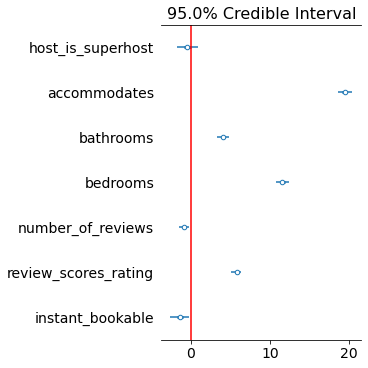

In [13]:
p_size = len(chains[0].regression_coefficients)
regressor_chains = {}
# covariates = ["intercept"] + covariates
for i, name in enumerate(covariates):
    regressor_chains[name] = np.array([c.regression_coefficients[i] for c in chains])

azChains = az.convert_to_inference_data(regressor_chains)
axes = az.plot_forest(azChains, credible_interval=0.95, figsize=(5, 5))
axes[0].axvline(color="red")
# plt.savefig("images/regression_coefficients_standardized.pdf")
plt.show()

## Couple of residual densities

In [14]:
def samplePredictiveRegression(chains, covariates, group):
    niter = len(chains)
    out = []
    num_comps = chains[0].num_components
    
    means_chain = np.vstack(
        [list(map(lambda x: x.mean, state.atoms)) for state in chains])

    stdevs_chain = np.vstack(
        [list(map(lambda x: x.stdev, state.atoms)) for state in chains])

    regressor_chains = np.vstack(
        [state.regression_coefficients for state in chains])

    weights_chains = np.vstack(
            [state.groupParams[group].weights for state in chains])
    
    preds = np.zeros(niter)
    for i in range(niter):
        means = np.dot(covariates, regressor_chains[i, :])
        cluster = np.apply_along_axis(
            lambda x: np.random.choice(range(num_comps), p=x), -1, 
            weights_chains[i, :])
        errs = norm.rvs(
            loc=means_chain[i, cluster], scale=stdevs_chain[i, cluster])
        preds[i] = means + errs
    
    return preds

In [15]:
import pandas as pd

df = pd.read_csv("data/amsterdam.csv")

KeyboardInterrupt: 

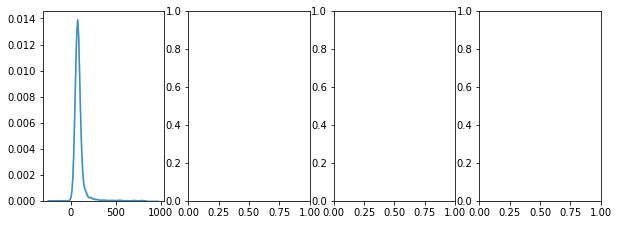

In [16]:
fig, axes = plt.subplots(nrows=1 , ncols=4, figsize=(10, 3.5))
toplot = [0, 9, 14, 19]


quantiles = [0.25, 0.5, 0.75]

plettes_by_neigh = [
    np.array(sns.color_palette("Blues", 10))[np.array([3, 6, 9])],
    np.array(sns.light_palette("orange", 10))[np.array([3, 6, 9])],
    np.array(sns.light_palette("green", 10))[np.array([3, 6, 9])],
    np.array(sns.light_palette("red", 10))[np.array([3, 6, 9])]
]


curr_covs = []
for q in [0.25, 0.5, 0.75]:
    bedroom_group = [
    np.quantile(df.cov_1.values, q), np.quantile(df.cov_2.values, q),
    np.quantile(df.cov_3.values, q)
    ]
    curr_covs.append(
        np.concatenate([[0], bedroom_group, [np.quantile(df.cov_4, 0.5)], 
                        [np.quantile(df.cov_5, 0.6)], [1]]))

for i in range(4):
    g = toplot[i]
    for k, covs in enumerate(curr_covs):
        pred_samples = samplePredictiveRegression(chains, covs, g)
        sns.kdeplot(pred_samples, ax=axes[i], color=plettes_by_neigh[i][k])

    axes[i].set_xlim(-50, 400)
    

plt.tight_layout()
# plt.savefig("images/dens_est_bedrooms.pdf")
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1 , ncols=1, figsize=(2.5, 3.5))


bedroom_group = [
    np.quantile(df.cov_1.values, q), np.quantile(df.cov_2.values, q),
    np.quantile(df.cov_3.values, q)
    ]

curr_covs = []
for q in [0.25, 0.5, 0.75]:
    curr_covs.append(
        np.concatenate([[0], bedroom_group, [np.quantile(df.cov_4, 0.5)], 
                        [np.quantile(df.cov_5, q)], [1]]))


g = 0
for k, covs in enumerate(curr_covs):
    pred_samples = samplePredictiveRegression(chains, covs, g)
    sns.kdeplot(pred_samples, color=plettes_by_neigh[g][k])
    
plt.xlim(-50, 400)
plt.tight_layout()
# plt.savefig("images/dens_est_reviews.pdf")
plt.show()

## Sigma

In [ ]:
mat = np.triu(np.asarray(chains[i].Sigma.data).reshape(4, 4))
mat[np.nonzero(mat)]

In [ ]:
H = chains[0].num_components
sigmaChain = np.zeros((len(chains), int((H-1)*(H) / 2)))
for i in range(len(chains)):
    mat = np.triu(np.asarray(chains[i].Sigma.data).reshape(H-1, H-1))
    sigmaChain[i, :] = mat[np.nonzero(mat)]
    
azChain = az.convert_to_inference_data(sigmaChain[np.newaxis, :])
axes = az.plot_trace(azChain)
axes = axes.flat

axnum = 0
for i in range(H - 1):
    for j in range(i+1):
        axes[axnum].set_title("Sigma_[{0}, {1}]".format(i+1, j+1))
        axes[axnum+1].set_title("Sigma_[{0}, {1}]".format(i+1, j+1))
        axnum += 2
        
# plt.savefig("images/sigma_dens_trace_amsterdam_standardized.pdf")
plt.show()

## rho

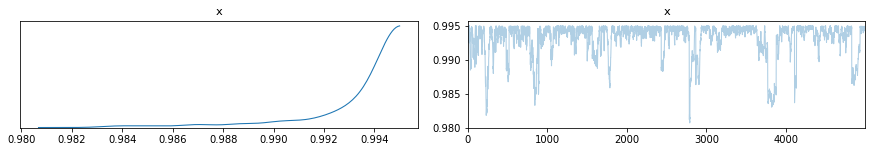

In [17]:
rhoChain = np.array([x.rho for x in chains])
    
azChain = az.convert_to_inference_data(rhoChain[np.newaxis, :])
axes = az.plot_trace(azChain)

# plt.savefig("images/rho_dens_trace_amsterdam_standardized.pdf")

In [18]:
np.mean(rhoChain)

0.993047279564364

In [19]:
np.std(rhoChain)

0.0024894247931122513

In [ ]:
from scipy.stats import norm

def mse(true_y, covs, areas, chains):
    niter = len(chains)
    preds = np.zeros((niter, len(true_y)))

    numGroups = len(chains[0].groupParams)
    num_components = chains[0].num_components

    means_chain = np.vstack(
        [list(map(lambda x: x.mean, state.atoms)) for state in chains])

    stdevs_chain = np.vstack(
        [list(map(lambda x: x.stdev, state.atoms)) for state in chains])

    regressor_chains = np.vstack(
        [state.regression_coefficients for state in chains])


    weights_chains = []
    for g in range(numGroups):
        weights_chains.append(np.vstack(
            [state.groupParams[g].weights for state in chains]))
    weights_chains = np.stack(weights_chains, axis=-1)

    for i in range(niter):
        means = np.dot(covs, regressor_chains[i, :])
        clusters = np.apply_along_axis(lambda x: np.random.choice(
            range(10), p=x), -1, weights_chains[i, :, areas])
        errs = norm.rvs(
            loc=means_chain[i, clusters], scale=stdevs_chain[i, clusters])
        preds[i, :] = means + errs

    predmean = np.mean(preds, axis=0)
    return np.sum((predmean - true_y)) ** 2

In [ ]:
mse(datas["y"][0], covariates_by_group[0], np.ones(len(datas["y"][0]), dtype=np.int32)  * 10, chains)

In [ ]:
mse(datas["y"][0], covariates_by_group[0], np.zeros(len(datas["y"][0]), dtype=np.int32), chains)

## Create DataFrame for CrossValidation

In [ ]:
import pandas as pd

df = None
colnames = ["group", "response"] + ["cov_{0}".format(i) for i in range(covariates_by_group[0].shape[1])]
for i in range(len(datas["y"])):
    group = np.ones(len(datas["y"][i])) * i
    currDf = np.hstack([
        group.reshape(-1, 1), 
        datas["y"][i].reshape(-1, 1), 
        covariates_by_group[i]])
    currDf = pd.DataFrame(currDf, columns=colnames)
    if df is None:
        df = currDf
    else:
        df = pd.concat([df, currDf])

In [ ]:
df.to_csv("data/amsterdam.csv")

In [ ]:
np.savetxt("data/gmat.txt", datas["G"])

# boxplots

In [ ]:
import pickle
import pandas as pd

with open("data/cross_val.pickle", "rb") as fp:
    cross_val_scores = pickle.load(fp)

In [ ]:
import matplotlib
import matplotlib.colors as mcolors

colors = [
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["steelblue"]),
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["orange"]), 
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["green"]),
    matplotlib.colors.to_rgba(mcolors.CSS4_COLORS["red"])]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cv_df = pd.DataFrame(cross_val_scores)
cv_df = pd.melt(cv_df)
cv_df.columns = ["H", "MSE"]

sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.boxplot(x="H", y="MSE", data=cv_df, palette=colors)
plt.tight_layout()
plt.savefig("mse_boxplots.pdf")